In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
import random
random.seed(41)
np.random.seed(41)

In [3]:
def transform_power(x, power):
    return x ** (1/power), {"power": power}

def inv_transform_power(x, power):
    return np.sign(x) * (np.abs(x) ** power)

In [4]:
def transform_boxcox(x):
    x_trans = []
    x_params = []
    for i in range(x.shape[1]):
        res = boxcox(x[:, i])
        data, data_lam = res
        x_trans.append(data)
        x_params.append(data_lam)
    x = np.array(x_trans).reshape((-1, x.shape[1]))
    params = {"lams": np.array(x_params).reshape((-1, x.shape[1]))}
    return x, params

def inv_t_boxcox(x, lams):
    x_inv = []
    for i in range(x.shape[1]):
        x_inv_yeo = inv_boxcox(x[:, i], float(lams[:, i]))
        x_inv.append(x_inv_yeo)
    return np.array(x_inv).reshape((-1, x.shape[1]))

In [5]:
def transform_yeo(x):
    x_trans = []
    x_params = []
    for i in range(x.shape[1]):
        data, data_lam = stats.yeojohnson(x[:, i])
        x_trans.append(data)
        x_params.append(data_lam)
    x = np.array(x_trans).reshape((-1, x.shape[1]))
    params = {"lams": np.array(x_params).reshape((-1, x.shape[1]))}
    return x, params

def inv_yeojohnson(x, lams):
    def inv(y, lam):
        v = y*lam + 1
        return np.sign(v) * (np.abs(v)**(1/lam)) - 1 # problème

    x_inv = []
    for i in range(x.shape[1]):
        x_inv_yeo = inv(x[:, i], float(lams[:, i]))
        x_inv.append(x_inv_yeo)
    return np.array(x_inv).reshape((-1, x.shape[1]))

In [6]:
def transform(x, name, **kwargs):
    if name == "power":
        power = kwargs["power"]
        return transform_power(x, power)
    elif name == "yeojohnson":
        return transform_yeo(x)
    elif name == "boxcox":
        return transform_boxcox(x)
    
def inv_transform(x, name, **kwargs):
    if name == "power":
        power = kwargs["power"]
        return inv_transform_power(x, power)
    elif name == "yeojohnson":
        lams = kwargs["lams"]
        return inv_yeojohnson(x, lams)
    elif name == "boxcox":
        lams = kwargs["lams"]
        return inv_t_boxcox(x, lams)

In [7]:
def train_model(train_data, name, **kwargs):
    train_data = np.array(train_data)
    data, params = transform(train_data, name, **kwargs)
    
    mu = np.mean(data, axis=0)
    cov = np.cov(data.T)
    B = np.linalg.cholesky(cov)
    return mu, B, params

In [8]:
def generate_data(Z, theta, name):
    mu, B, params = theta
    X_temp = np.dot(Z, B.T)
    X = (mu - X_temp.mean(0) + X_temp)
    generated_data = inv_transform(X, name, **params)
    return generated_data

In [9]:
import metrics

In [10]:
def evaluate(val, X_gen, p=False):
    m_kend = metrics.absolute_kendall_error(val, X_gen)
    m_and = metrics.marginals_anderson_darling(val, X_gen)
    if p:
        print(f"Anderson : {m_and:5f}\nKendall : {m_kend:5f}")
    return m_kend, m_and

In [11]:
train = pd.read_csv("./input/train.csv", header=None, index_col=0)
train.head()

,1,2,3,4
0,,,,
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


In [12]:
val = pd.read_csv("./input/data_val_log_return.csv", header=None, index_col=0)
val.head()

,1,2,3,4
0,,,,
0,0.004108,0.002495,0.000915,0.004529
1,0.009841,0.027978,0.031471,0.001886
2,0.002972,0.001509,0.004137,0.001496
3,0.013441,0.017132,0.019585,0.012195
4,0.006110,0.001199,0.007887,0.001790


In [13]:
z_dim = 4
mu_Z = np.zeros(z_dim)
cov_Z = np.eye(z_dim)
Z = np.random.multivariate_normal(mu_Z, cov_Z, 410)

In [14]:
power = 4

In [15]:
X_gen = generate_data(
    Z,
    train_model(train, "power", **{"power": power}), 
    "power"
)
evaluate(val, X_gen, p=True)

Anderson : 1.769483
Kendall : 0.207031


(0.20703083069950487, 1.7694825359742197)

In [16]:
X_gen = generate_data(
    Z,
    train_model(train, "yeojohnson"), 
    "yeojohnson"
)
evaluate(val, X_gen, p=True)

Anderson : 13.840871
Kendall : 0.174870


(0.17487029638022553, 13.840870971061818)

In [17]:
X_gen = generate_data(
    Z,
    train_model(train.values, "boxcox"), 
    "boxcox"
)
evaluate(val, X_gen, p=True)

Anderson : 45.625373
Kendall : 0.179683


(0.17968274792772382, 45.62537303020177)

In [18]:
powers = np.linspace(1, 10, 30)

In [19]:
results = []
for power in powers:
    X_gen = generate_data(
        Z,
        train_model(train, "power", **{"power": power}), 
        "power"
    )
    m_kend, m_and = evaluate(val, X_gen, p=False)
    results.append([m_and, m_kend])
results = np.array(results)

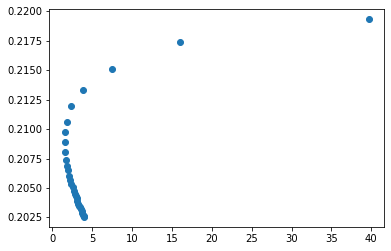

In [21]:
plt.scatter(results[:, 0], results[:,1])
plt.show()

In [22]:
results

array([[39.71120286,  0.2193154 ],
       [16.01862844,  0.21734749],
       [ 7.41058022,  0.21509929],
       [ 3.8658136 ,  0.21333413],
       [ 2.35932276,  0.21198044],
       [ 1.77295494,  0.21059097],
       [ 1.56633616,  0.20978591],
       [ 1.51310665,  0.20893315],
       [ 1.58414607,  0.20808039],
       [ 1.68490209,  0.20734093],
       [ 1.80779845,  0.20686982],
       [ 1.94762312,  0.20650605],
       [ 2.09465097,  0.2060588 ],
       [ 2.2310355 ,  0.20567118],
       [ 2.37046698,  0.2053253 ],
       [ 2.516761  ,  0.20505099],
       [ 2.65319675,  0.204723  ],
       [ 2.78366634,  0.20449043],
       [ 2.90756929,  0.20433538],
       [ 3.01517096,  0.20413263],
       [ 3.12739854,  0.20392391],
       [ 3.23559293,  0.20364363],
       [ 3.34813065,  0.2034528 ],
       [ 3.45422438,  0.20335142],
       [ 3.55597167,  0.20322619],
       [ 3.64980825,  0.20305325],
       [ 3.73466704,  0.20288628],
       [ 3.81411481,  0.20273719],
       [ 3.89752897,

In [23]:
powers[8]

3.4827586206896552

In [24]:
powers[7]

3.1724137931034484

In [25]:
X_gen = generate_data(
    Z,
    train_model(train, "power", **{"power": 3.1724137931034484}), 
    "power"
)

In [26]:
def display_data(fake_data, train_data):
    fake_data = pd.DataFrame(np.array(fake_data))
    fake_data.head()

    train_data = pd.DataFrame(np.array(train_data))
    train_data.head()

    fake_data["label"] = 1
    train_data["label"] = 0
    
    data = pd.concat([fake_data, train_data])
    data.head()

    sns.pairplot(data, hue='label')

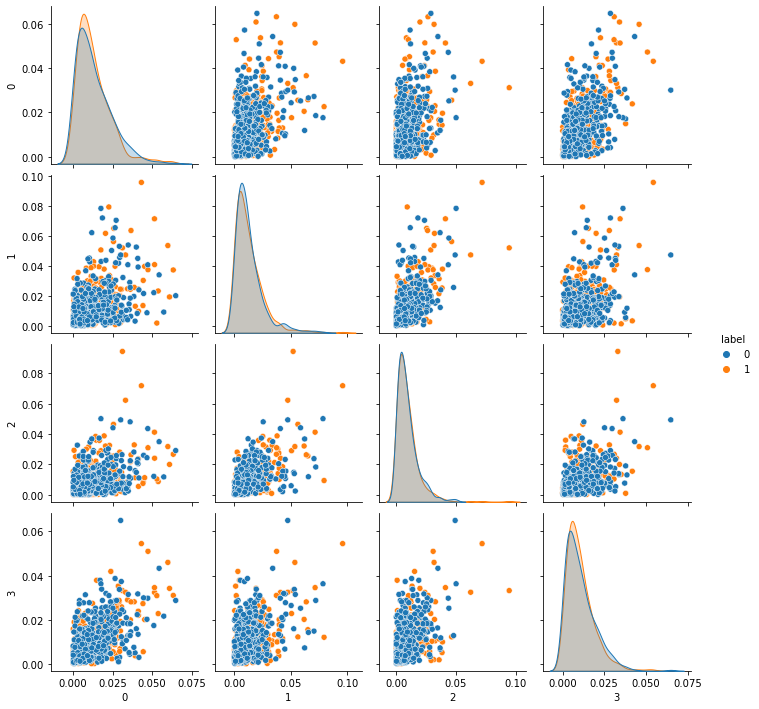

In [27]:
display_data(val, X_gen)

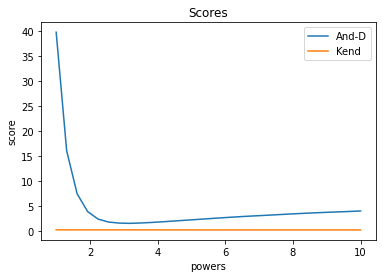

In [28]:
plt.plot(powers, results[:, 0])
plt.plot(powers, results[:, 1])
plt.xlabel('powers')
plt.ylabel('score')
plt.legend(['And-D', 'Kend'])
plt.title('Scores')

plt.show()

In [29]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

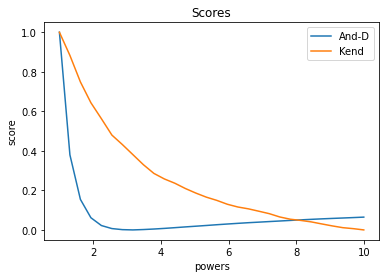

In [30]:
plt.plot(powers, mm.fit_transform(results)[:, 0])
plt.plot(powers, mm.fit_transform(results)[:, 1])
plt.xlabel('powers')
plt.ylabel('score')
plt.legend(['And-D', 'Kend'])
plt.title('Scores')
 
plt.show()

In [18]:
X_gen = generate_data(
    Z,
    train_model(train, "power", **{"power": 8}), 
    "power"
)

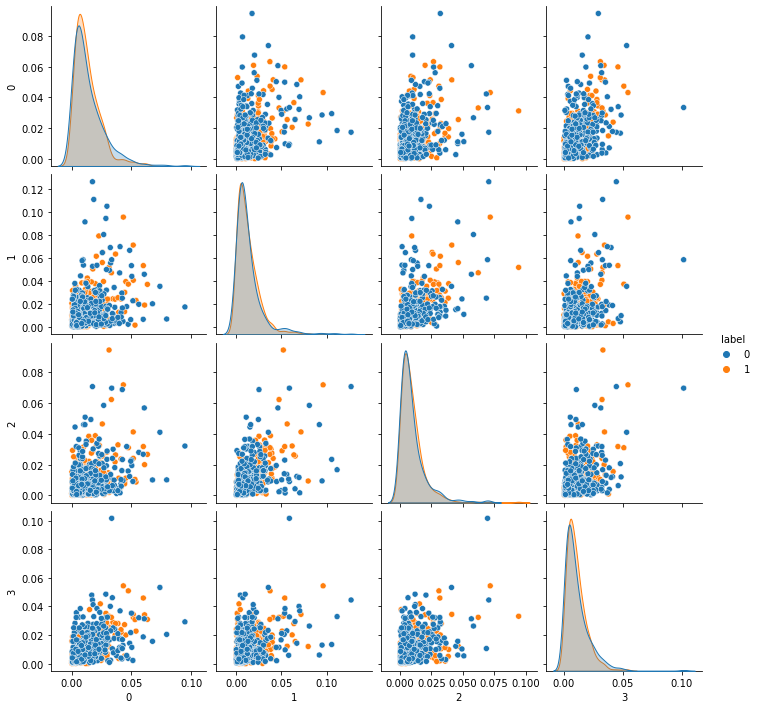

In [21]:
display_data(val, X_gen)

In [22]:
evaluate(val, X_gen, p=True)

Anderson : 3.660422
Kendall : 0.203405


(0.20340509273063376, 3.6604224745402405)

In [23]:
X_gen = generate_data(
    Z,
    train_model(train, "power", **{"power": 4}), 
    "power"
)

In [24]:
evaluate(val, X_gen, p=True)

Anderson : 1.893738
Kendall : 0.207031


(0.20703083069950487, 1.8937375843162698)

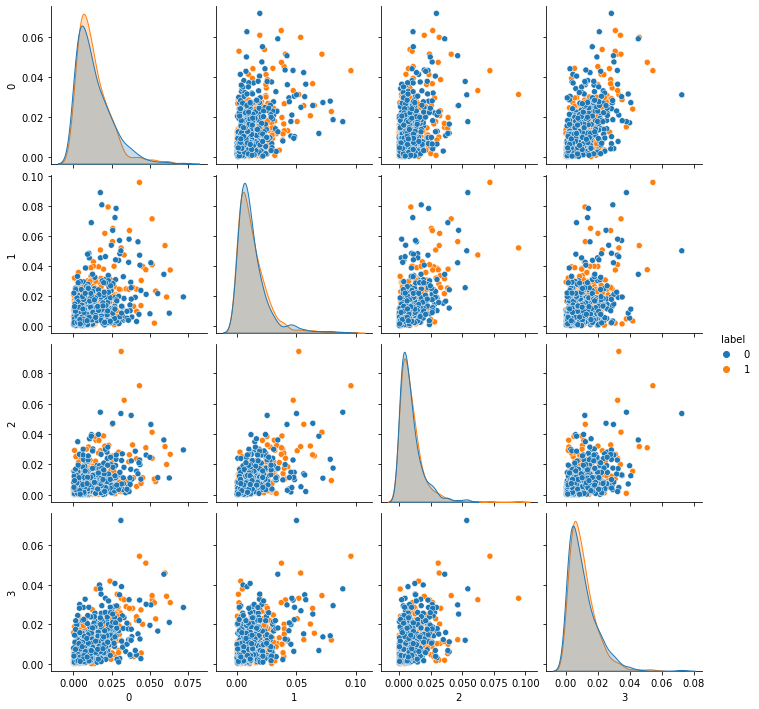

In [25]:
display_data(val, X_gen)

In [13]:
np.linalg.cholesky?

Signature: np.linalg.cholesky(a)
Docstring:
Cholesky decomposition.

Return the Cholesky decomposition, `L * L.H`, of the square matrix `a`,
where `L` is lower-triangular and .H is the conjugate transpose operator
(which is the ordinary transpose if `a` is real-valued).  `a` must be
Hermitian (symmetric if real-valued) and positive-definite. No
checking is performed to verify whether `a` is Hermitian or not.
In addition, only the lower-triangular and diagonal elements of `a`
are used. Only `L` is actually returned.

Parameters
----------
a : (..., M, M) array_like
    Hermitian (symmetric if all elements are real), positive-definite
    input matrix.

Returns
-------
L : (..., M, M) array_like
    Upper or lower-triangular Cholesky factor of `a`.  Returns a
    matrix object if `a` is a matrix object.

Raises
------
LinAlgError
   If the decomposition fails, for example, if `a` is not
   positive-definite.

See Also
--------
scipy.linalg.cholesky : Similar function in SciPy.
scipy.lina